### <span style="font-family: Times New Roman;">27 - Traffic and Population Data Check.</span>


### <span style="font-family: Times New Roman;">Gabi Rayman, Elior Dahan, Yashiv Dafna, Amichai Nagar.</span>


# Preparing the data and arranging the table 

1. The original data is in Hebrew and to simplify the process of working with the code we translated the data using Google translate api
2. Because of the literal translation of the Google Translate plugin, we added the column `area name` from the original data to compare the translation with the original




---
> <font size=4 > **Column guide:**</font>
>
>* `TAZ_Number` - plot number according to the division of the 'Tzevet Av Latachnura'
>
>* `en_area name` - the area name after the translation
>
>* `area name` - the original area name in Hebrew before the translation
>
>* `Authority` - the name of the authority
>
>* `Inside the city of Jerusalem?` - binary
>* `Inside the Jerusalem metropolis?` - binary
>
>* `sector` - determined by the majority of the population in the area.
Five sectors: Ultra Orthodox , Jewish,  Arabs beyond the separation fence,
       Arab,  Palestinian 
>              
>**The following columns are 7 parameters which in a general name can be called traffic generators. Each parameter has a forecast for each five-year period until 2040.**
>
>* `Additional unit` - the number of housing units that were added
>
>* `Gm_b average` - average household size
>
>* `population` - population size forecast
>* `Total students` - number of school students in the area
>* `Total employed` - number of employees working in the area
>* `Total Yeshiva students and include` - The number of yeshiva students and kollels in the area
>* `Higher education students` - number of students in the area
>* `Units per square kilometer - 2020'`
>* `Units per square kilometer - 2040'`
>* `Employed per square kilometer - 2020`
>* `Employed per square kilometer - 2040`
---

Total rows and columns in the data: (897, 50)

<img src="https://raw.githubusercontent.com/gabirayman/Final-project-english/main/6020cbb8-cdcb-4bae-895b-96f46812d2f9.jpeg" width="600"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.simplefilter(action='ignore')

In [2]:
urll = 'https://raw.githubusercontent.com/gabirayman/Final-project-english/main/%D7%AA%D7%97%D7%96%D7%99%D7%95%D7%AA_%D7%9C%D7%A4%D7%99_%D7%90%D7%96%D7%95%D7%A8%D7%99_%D7%AA%D7%A0%D7%95%D7%A2%D7%94_%D7%92%D7%A8%D7%A1%D7%90_3_2_3447844572378810775%20(1).csv'
orig_data = pd.read_csv(urll)

In [3]:
url = 'https://raw.githubusercontent.com/gabirayman/Final-project-english/main/data%20for%20project.csv'
source_data = pd.read_csv(url)
source_data.drop('Unnamed: 0', axis = 1, inplace=True)

In [4]:
data = source_data.copy()

data.drop('OBJECTID', axis = 1, inplace=True)
data.drop('Traffic area', axis = 1, inplace=True)

In [5]:
data.insert(2, 'area name', orig_data['שם אזור'])

<font color="red" size=4 >**Our goal in this work is to analyze the data and find potential problems with the data**</font>

# Suspicious Rows

After working on the data we realized that there are lines that, in certain parameters, behave in a way that may indicate that the predictions in this parameter are incorrect. We are not necessarily saying that these data are wrong, but at the very least these data are suspected to be unreliable and should be examined again.  
We tried to give a "suspicion" rating to the parameters in the lines in the following way:
1. Parameters in which all the values in the forecast are the same (that is, there has been no change at all over the years) received the grade 1
2. Parameters in which the values in each forecast increase by a fixed number received the grade 2
3. Parameters that do not behave like the two above received the score 0
- We decided not to rank parameters in which the values of all predictions are 0 as parameters that behave suspiciously. *In any case, we built a function that can mark these parameters with a score of 3*

<center> "Suspicion" score summary </center>

|   same values    | constant jump | Unsuspected data    |
| :---:        |    :----:   |          :---: |
| 1      | 2       | 0   |


In [6]:
def mark_same_values(df, columns, score):
    same_values_rows = df[df[columns].apply(lambda x: (x == x.iloc[0]).all(), axis=1)]
    df.loc[same_values_rows.index, score] = 1

def mark_0_values(df, columns, score):
    same_values_rows = df[df[columns].apply(lambda x: (x == 0.0).all(), axis=1)]
    df.loc[same_values_rows.index, score] = 3
    
def mark_same_values_without_0 (df, columns, score):
    same_values_rows = df[df[columns].apply(lambda x: (x == x.iloc[0]).all() and x.iloc[0]!=0.0 , axis=1)]
    df.loc[same_values_rows.index, score] = 1
    
def mark_constant_jump(df, columns, score):
    constant_jump_rows = df[df[columns].diff(axis=1).apply(lambda x: len(x.unique()) == 2 and 0.0 not in x.unique(), axis=1)]
    df.loc[constant_jump_rows.index, score] = 2
    
def check_same_values(df, columns):
    same_values_rows = df[df[columns].apply(lambda x: (x == x.iloc[0]).all(), axis=1)]
    return same_values_rows

def check_constant_jump(df, columns):
    constant_jump_rows = df[df[columns].diff(axis=1).apply(lambda x: len(x.unique()) == 2 and 0.0 not in x.unique(), axis=1)]
    return constant_jump_rows

In the next line of code we add columns to the table with the scores of the parameters

In [7]:
reliable_data = data.copy()
#Scored data where a parameter equals 0 is considered normal
reliable_data_true_rows = data.copy()
#Scored data where a parameter equals 0 received a score of 3
reliable_data_true_rows_full = data.copy()

In [8]:
dic = {"Additional unit":['Additional unit 2020_ 2025','Additional unit 2025_ 2030', 'Additional unit 2030_ 2035','Addendum y_d 2035_ 2040'],\
       "Gm_b average":['Gm_b average 2020', 'Gm_b average 2025','Gm_b average 2030', 'Gm_b average 2035', 'Gm_b average 2040'],\
       "population":['2020 population projections', 'Population projections 2025','Population projections 2030', '2035 population projections','Population projections 2040'],\
       "Total students":['Total students 2020','Total students 2025', 'Total students 2030', 'Total students 2035','Total students 2040'],\
       "Total employed":['Total employed 2020', 'Total employed 2025','Total employed 2030', 'Total employed 2035', 'Total employed 2040'],\
       "Yeshiva students":['Total Yeshiva students and include 2020','Total Yeshiva students and include 2025','Total Yeshiva students and include 2030','Total yeshiva students and include 2035','Total Yeshiva students including 2040'],\
       "Higher education students":['Higher education students 2020', 'Higher education students 2025','Higher education students 2030', 'Higher education students 2035','Higher education students 2040']}

for key in dic.keys():
    reliable_data.insert(7,key,0)
    reliable_data_true_rows.insert(7,key,0)
    reliable_data_true_rows_full.insert(7,key,0)    
for key, value in dic.items():
    mark_same_values(reliable_data, value, key)
    mark_constant_jump(reliable_data, value, key)
    mark_same_values_without_0(reliable_data_true_rows, value, key)
    mark_constant_jump(reliable_data_true_rows, value, key)
    mark_same_values_without_0(reliable_data_true_rows_full, value, key)
    mark_constant_jump(reliable_data_true_rows_full, value, key)
    mark_0_values(reliable_data_true_rows_full, value, key)


In [9]:
parameters = ['en_area name','area name','Authority','sector']
reliable_data_true_rows[parameters+list(dic.keys())].head(3)

,en_area name,area name,Authority,sector,Additional unit,Gm_b average,population,Total students,Total employed,Yeshiva students,Higher education students
0,Neve Ya'akov - commercial center,נוה יעקב - מרכז מסחרי,Jerusalem,Ultra Orthodox,1,0,0,0,0,1,0
1,Neve Yaakov Tathon,נוה יעקב תחתון,Jerusalem,Jewish,1,0,0,0,0,1,0
2,Ramot - a pool of water,רמות - בריכת מים,Jerusalem,Ultra Orthodox,0,0,0,0,0,0,0


**row ranking:**  
To get an overview of the data, we will look at all the data by scores for the rows. The score for the row counts the parameters in which a "suspicion" score was received (a score that is not 0), so each row can receive a score between 0 (reliable) and 7 (unreliable).

In [10]:
#rows where the parameter equals 0 is considered an abnormal
count_data=reliable_data[parameters+list(dic.keys())]
count_data['count']=0

count_data3=reliable_data_true_rows_full[parameters+list(dic.keys())]
count_data3['count']=0
count_data3.head(3)

#rows where the parameter equals 0 is considered a normal
count_data2=reliable_data_true_rows[parameters+list(dic.keys())]
count_data2['count']=0

In [11]:
local_sum=0
for i in range(len(count_data)):
    for j in range(4,11):
        if count_data2.iloc[i,j]==2:
            local_sum+=1
        else:
            local_sum+=count_data2.iloc[i,j]
    count_data2.iloc[i,11]+=local_sum
    local_sum=0

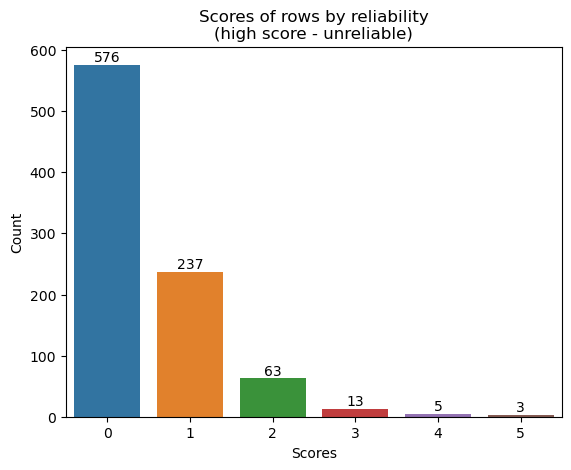

In [12]:
sns.countplot(data=count_data2,x=count_data2['count']);
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                       ha='center', va='bottom')
plt.xlabel('Scores')
plt.ylabel('Count')
plt.title('Scores of rows by reliability\n(high score - unreliable)')
plt.show()

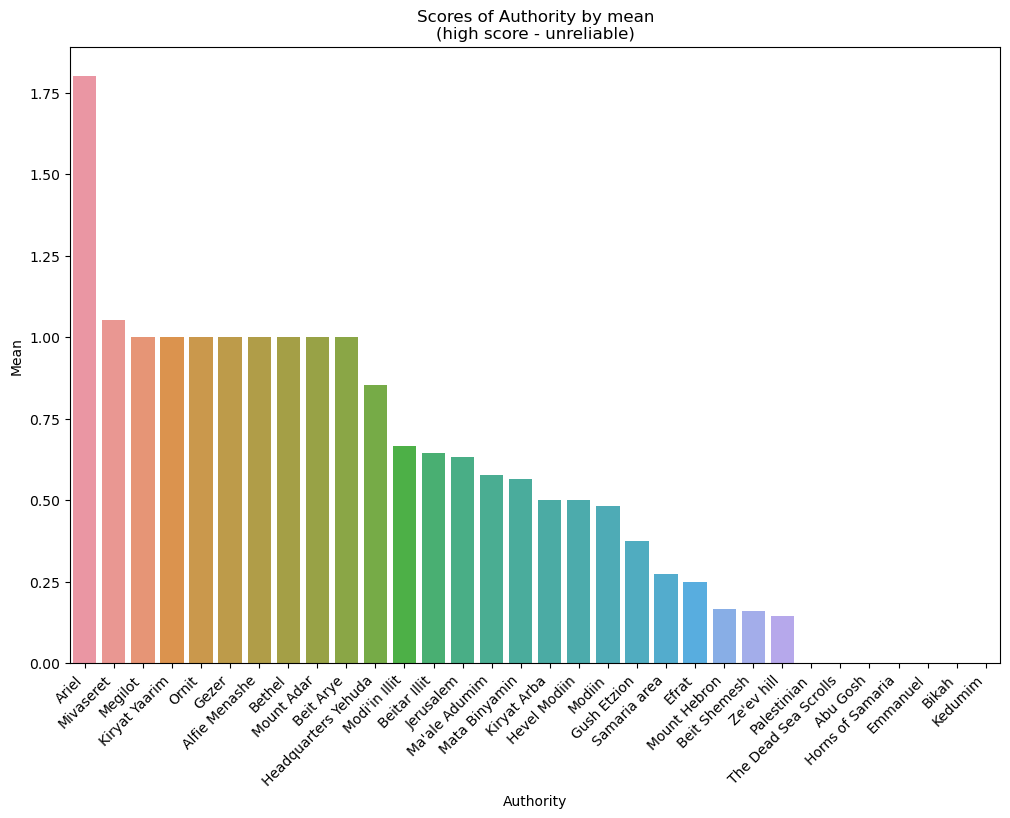

In [13]:
plt.figure(figsize=(12,8))
coun_group_au=count_data2.groupby('Authority').mean()
coun_group_au.sort_values('count',ascending=False,inplace=True)
sns.barplot(data=coun_group_au\
            ,x=coun_group_au.index,y=coun_group_au['count'])
plt.xlabel('Authority')
plt.ylabel('Mean')
plt.title('Scores of Authority by mean\n(high score - unreliable)')
plt.xticks(rotation=45,ha='right')
plt.show;

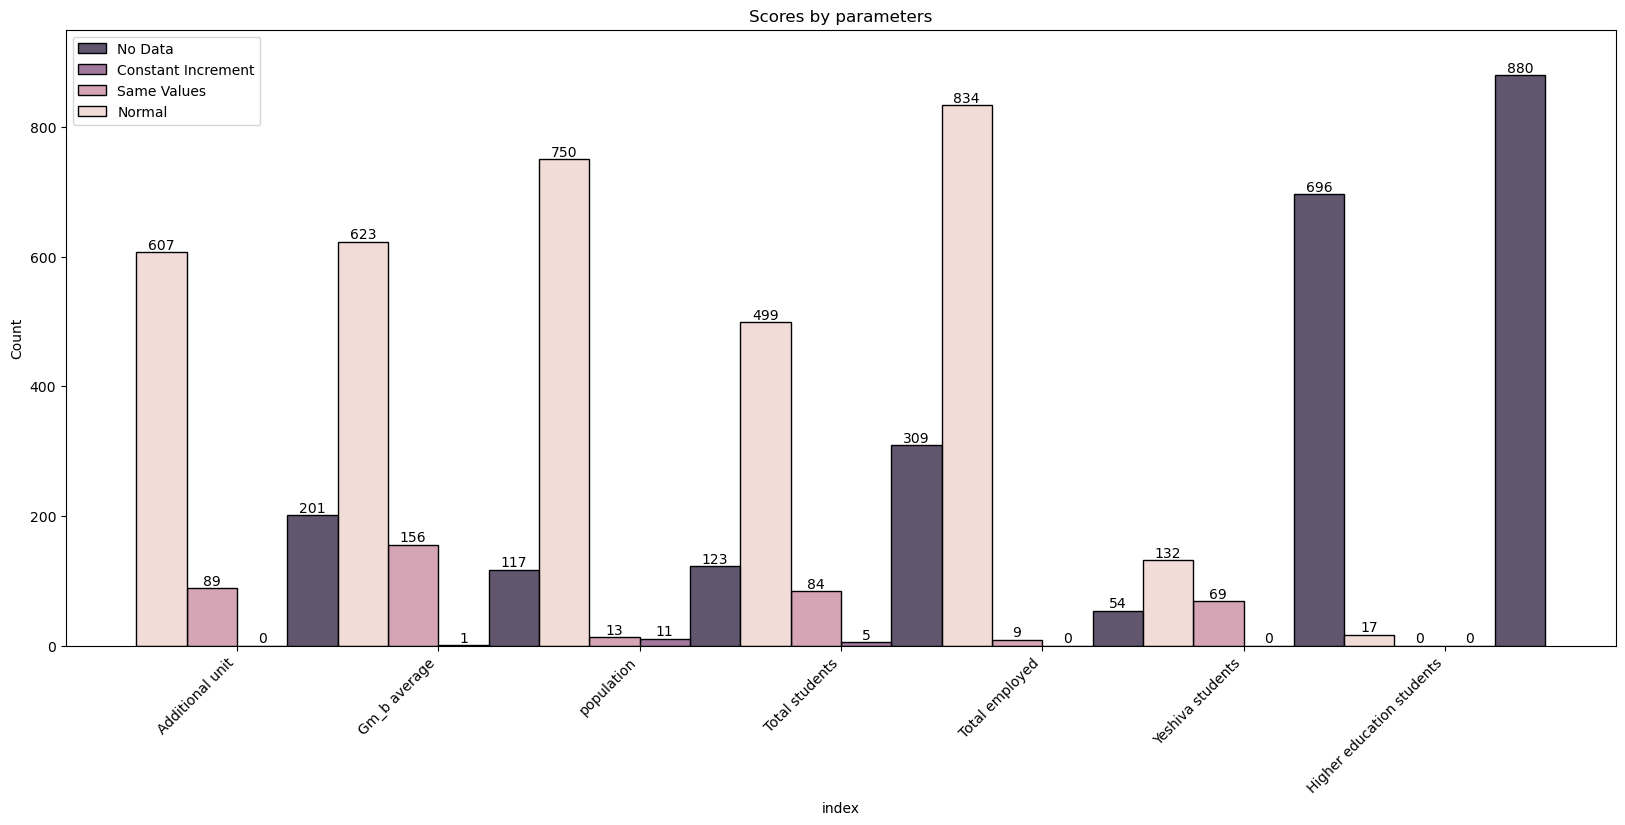

In [14]:
df = reliable_data_true_rows_full[dic.keys()].transpose().reset_index()

df = pd.melt(df, id_vars =['index'])
#df = df.groupby(['index','value']).count()
#df = df.reset_index()

fig, ax = plt.subplots(figsize = (20,8))



sns.histplot(data=df, x='index' ,hue='value', multiple = 'dodge',bins=0.3)
plt.xticks(rotation=45,ha='right')
for p in plt.gca().patches:
        height = p.get_height()
        plt.gca().annotate(f'{height}', (p.get_x() + p.get_width() / 2, height),
                           ha='center', va='bottom')

plt.title('Scores by parameters')
plt.ylim(0,950)
plt.legend(['No Data','Constant Increment','Same Values','Normal'])
plt.show()

## duplicate rows

In [15]:
def chek_duplicated (data, columns_to_check):
    duplicated = data[data.duplicated(columns_to_check, keep=False)]
    return duplicated.groupby(['sector',columns_to_check[0]]).count()
    

In [16]:
columns_to_check = ['Total employed 2020','Total employed 2025', 'Total employed 2030', 'Total employed 2035',
       'Total employed 2040']
chek_duplicated (data, columns_to_check)

TAZ_Number  en_area name  area name  \
sector         Total employed 2020                                        
Arab           0.000000                      4             4          4   
Jewish         0.000000                     28            28         28   
               11.681003                     2             2          2   
               250.000000                    1             1          1   
Palestinian    0.000000                      5             5          5   
               37.448047                     8             8          8   
               44.937656                    25            25         25   
               53.468950                     4             4          4   
               93.620117                     4             4          4   
               93.906351                     6             6          6   
               133.672374                   10            10         10   
               187.812701                   17            17         17   
Ultra Orthodox 0.000000                     14            14         14   
               250.000000                    1             1          1   

                                    Authority  Inside the city of Jerusalem?  \
sector         Total employed 2020                                             
Arab           0.000000                     4                              4   
Jewish         0.000000                    28                             28   
               11.681003                    2                              2   
               250.000000                   1                              1   
Palestinian    0.000000                     5                              5   
               37.448047                    8                              8   
               44.937656                   25                             25   
               53.468950                    4                              4   
               93.620117                    4                              4   
               93.906351                    6                              6   
               133.672374                  10                             10   
               187.812701                  17                             17   
Ultra Orthodox 0.000000                    14                             14   
               250.000000                   1                              1   

                                    Inside the Jerusalem metropolis?  \
sector         Total employed 2020                                     
Arab           0.000000                                            4   
Jewish         0.000000                                           28   
               11.681003                                           2   
               250.000000                                          1   
Palestinian    0.000000                                            5   
               37.448047                                           8   
               44.937656                                          25   
               53.468950                                           4   
               93.620117                                           4   
               93.906351                                           6   
               133.672374                                         10   
               187.812701                                         17   
Ultra Orthodox 0.000000                                           14   
               250.000000                                          1   

                                    A total of one until 2020  \
sector         Total employed 2020                              
Arab           0.000000                                     4   
Jewish         0.000000                                    28   
               11.681003                                    2   
               250.000000                                   1   
Palestinian

The duplicate rows in the data are rows with geographic proximity. 

It can be assumed that there is data for a certain city but there is no data for the geographical distribution of 'Tzevet Av Latachnura', so the city's data is taken and divided equally between all parts of 'Tzevet Av Latachnura'.  

*Please note* that the interactive map on the website can be misleading because the data is colored according to density and the density is calculated according to the data divided by the area, therefore because the size of the areas are different and the data itself is the same, it can appear that there are dense places but in reality they are not.

These errors are found mainly in the Arab territories of Judea and Shimron. The cities of Ramallah, Bethlehem and Hebron.

There are such phenomena in the non-Arab sectors as well, but the doubling is only in certain parameters and not in the whole line.

<img src="https://raw.githubusercontent.com/gabirayman/Final-project-english/main/87bf60f2-6436-4791-be60-d30076dc7a5f.jpeg" width="600"/>

# We will now dive into the data and see if the data makes sense

## We will start by looking at the population devided by sector

In [17]:
df2 = source_data.copy()

In [18]:
df_sum = df2.groupby(['sector']).sum()

In [19]:
pop = ['2020 population projections', 'Population projections 2025',
       'Population projections 2030', '2035 population projections',
       'Population projections 2040']

In [20]:
df_sum_pop = df_sum[pop].reset_index()

In [21]:
df_sum_pop

,sector,2020 population projections,Population projections 2025,Population projections 2030,2035 population projections,Population projections 2040
0,Arab,3.180772e+05,3.463369e+05,3.885559e+05,4.273298e+05,4.678762e+05
1,Arabs beyond the separation fence,1.063511e+05,1.202697e+05,1.374174e+05,1.550388e+05,1.724232e+05
2,Jewish,9.204880e+05,1.023760e+06,1.180334e+06,1.363870e+06,1.539443e+06
3,Palestinian,2.744221e+06,3.000269e+06,3.248011e+06,3.483049e+06,3.703893e+06
4,Ultra Orthodox,4.910456e+05,5.745892e+05,6.834154e+05,7.769754e+05,8.376611e+05


In [22]:
df_sum_pop_melt = df_sum_pop.melt(id_vars = ['sector'])

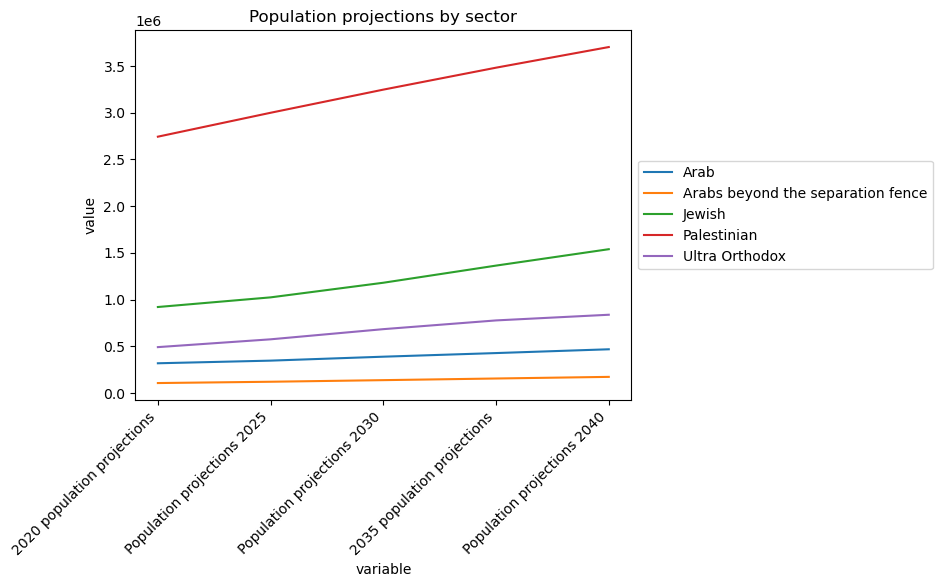

In [23]:
sns.lineplot(data=df_sum_pop_melt, x = 'variable',y='value', hue='sector')
plt.xticks(rotation=45,ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Population projections by sector')
plt.show()

Making Dataframe for growth of population

In [24]:
# Create a new DataFrame for growth
df_growth = pd.DataFrame()

# Iterate over columns and calculate growth
for i in range(2, len(df_sum_pop.columns)):
    column_name = df_sum_pop.columns[i]
    previous_column = df_sum_pop.columns[i-1]
    df_growth[column_name] = df_sum_pop[column_name] - df_sum_pop[previous_column]
df_growth['sector'] = list(df_sum_pop.sector)
df_growth=df_growth.set_index('sector')
df_growth=df_growth.reset_index()
# Display the new DataFrame
df_growth


,sector,Population projections 2025,Population projections 2030,2035 population projections,Population projections 2040
0,Arab,28259.637934,42219.049090,38773.874243,40546.430428
1,Arabs beyond the separation fence,13918.614711,17147.731765,17621.411812,17384.335798
2,Jewish,103271.971439,156574.082064,183536.418999,175572.161140
3,Palestinian,256047.419251,247741.840817,235038.606377,220844.169512
4,Ultra Orthodox,83543.669626,108826.127717,93559.977812,60685.708915


Making Dataframe for growth of population percentages to compare to other data

In [25]:
df_growth_percentage = pd.DataFrame()

# Iterate over columns and calculate percentage growth
for i in range(2, len(df_sum_pop.columns)):
    column_name = df_sum_pop.columns[i]
    previous_column = df_sum_pop.columns[i-1]
    df_growth_percentage[column_name] = ((df_sum_pop[column_name] - df_sum_pop[previous_column]) / df_sum_pop[previous_column]) * 100
df_growth_percentage['sector'] = list(df_sum_pop.sector)
df_growth_percentage=df_growth_percentage.set_index('sector')
df_growth_percentage=df_growth_percentage.reset_index()
# Display the new DataFrame
df_growth_percentage.columns = ['sector','2025','2030','2035','2040']
df_growth_percentage

,sector,2025,2030,2035,2040
0,Arab,8.884521,12.190169,9.978969,9.488323
1,Arabs beyond the separation fence,13.087424,14.257734,12.823274,11.212892
2,Jewish,11.219263,15.294022,15.549532,12.873082
3,Palestinian,9.330422,8.257322,7.236387,6.340541
4,Ultra Orthodox,17.013425,18.939813,13.690060,7.810506


In [26]:
df_growth_percentage_num = df_growth_percentage[list(df_growth_percentage.columns)[1:]]

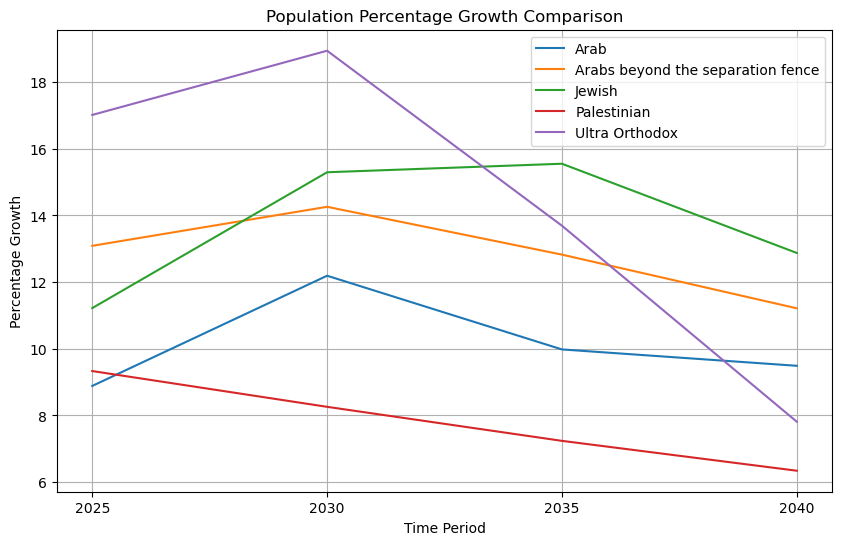

In [27]:
plt.figure(figsize=(10, 6))
for place in df_growth_percentage_num.index:
    plt.plot(df_growth_percentage_num.loc[place], label=place)
plt.xlabel('Time Period')
plt.ylabel('Percentage Growth')
plt.title('Population Percentage Growth Comparison')
plt.legend(df_growth_percentage['sector'])
plt.grid(True)
plt.show()

We see that the palestinian growth rate is similar to this graph from https://worldpopulationreview.com/ 

<img src="https://raw.githubusercontent.com/gabirayman/Final-project-english/main/Screenshot%202023-06-16%20172430.png" width="600"/>

## We will now compare the data with external data on general Israeli poputlation

In [28]:
total_population = df_sum_pop.sum(axis=0)

# Convert the total_population Series into a DataFrame with a single row
total_population_df = pd.DataFrame(total_population).T

# Assign a label to the row
total_population_df.index = [5]

# Concatenate the total_population_df with the original DataFrame
df_with_total = pd.concat([df_sum_pop, total_population_df])

df_with_total.iloc[5,0] = 'Total'

df_with_total

,sector,2020 population projections,Population projections 2025,Population projections 2030,2035 population projections,Population projections 2040
0,Arab,318077.23322,346336.871154,388555.920243,427329.794486,467876.224915
1,Arabs beyond the separation fence,106351.067253,120269.681964,137417.413729,155038.825541,172423.161339
2,Jewish,920488.015634,1023759.987072,1180334.069136,1363870.488135,1539442.649275
3,Palestinian,2744221.260032,3000268.679283,3248010.5201,3483049.126477,3703893.295989
4,Ultra Orthodox,491045.577388,574589.247014,683415.374732,776975.352544,837661.061459
5,Total,4580183.153526,5065224.466487,5637733.297941,6206263.587184,6721296.392976


In [29]:
df_growth_percentage_with_total = pd.DataFrame()

# Iterate over columns and calculate percentage growth
for i in range(2, len(df_with_total.columns)):
    column_name = df_with_total.columns[i]
    previous_column = df_with_total.columns[i-1]
    df_growth_percentage_with_total[column_name] = ((df_with_total[column_name] - df_with_total[previous_column]) / df_with_total[previous_column]) * 100
df_growth_percentage_with_total['sector'] = list(df_with_total.sector)
df_growth_percentage_with_total=df_growth_percentage_with_total.set_index('sector')
df_growth_percentage_with_total=df_growth_percentage_with_total.reset_index()
# Display the new DataFrame
df_growth_percentage_with_total.columns = ['sector','2025','2030','2035','2040']
df_growth_percentage_with_total

,sector,2025,2030,2035,2040
0,Arab,8.884521,12.190169,9.978969,9.488323
1,Arabs beyond the separation fence,13.087424,14.257734,12.823274,11.212892
2,Jewish,11.219263,15.294022,15.549532,12.873082
3,Palestinian,9.330422,8.257322,7.236387,6.340541
4,Ultra Orthodox,17.013425,18.939813,13.69006,7.810506
5,Total,10.589998,11.302734,10.084377,8.298597


## For comparison from government statistics website

In [30]:
url2 = 'https://raw.githubusercontent.com/gabirayman/Final-project-english/main/for-compare.csv'
compare = pd.read_csv(url2)
compare.drop(['Unnamed: 5','Unnamed: 6'], axis=1,inplace = True)
compare.columns = ['Year','High','Medium','Low','Estimate']
compare_rel = compare[(compare['Year'] == 2020)|(compare['Year'] == 2025)|(compare['Year'] == 2030)|(compare['Year'] == 2035)|(compare['Year'] == 2040)]
compare_rel = compare_rel[list(compare_rel.columns)[:4]]
compare_rel = compare_rel.transpose()
compare_rel.columns = ['2020','2025','2030','2035','2040']
compare_rel = compare_rel.iloc[1:]
compare_rel

,2020,2025,2030,2035,2040
High,9.4,10.4,11.5,12.8,14.2
Medium,9.3,10.2,11.1,12.1,13.2
Low,9.2,10.0,10.7,11.5,12.3


In [31]:
df_growth_percentage_compare = pd.DataFrame()

# Iterate over columns and calculate percentage growth
for i in range(1, len(compare_rel.columns)):
    column_name = compare_rel.columns[i]
    previous_column = compare_rel.columns[i-1]
    df_growth_percentage_compare[column_name] = ((compare_rel[column_name] - compare_rel[previous_column]) / compare_rel[previous_column]) * 100

# Display the new DataFrame
df_growth_percentage_compare

,2025,2030,2035,2040
High,10.638298,10.576923,11.304348,10.937500
Medium,9.677419,8.823529,9.009009,9.090909
Low,8.695652,7.000000,7.476636,6.956522


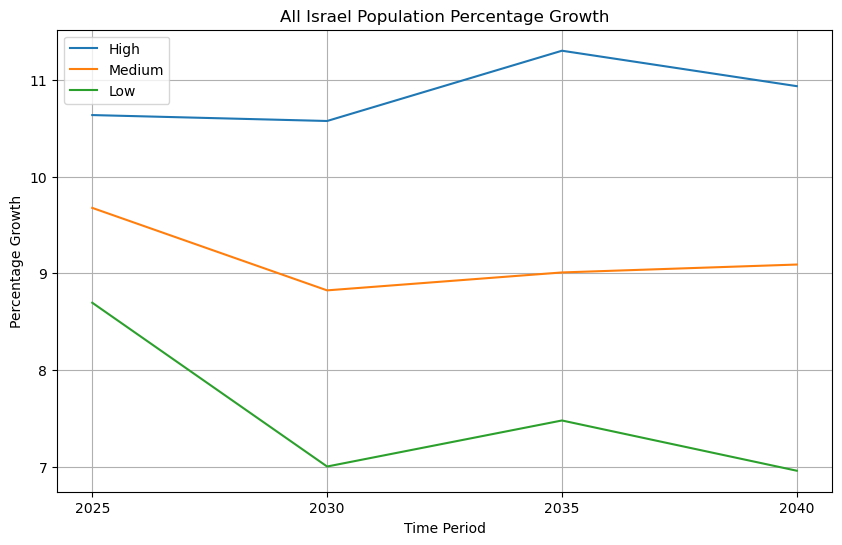

In [32]:
plt.figure(figsize=(10, 6))
for place in df_growth_percentage_compare.index:
    plt.plot(df_growth_percentage_compare.loc[place], label=place)
plt.xlabel('Time Period')
plt.ylabel('Percentage Growth')
plt.title('All Israel Population Percentage Growth')
plt.legend()
plt.grid(True)
plt.show()

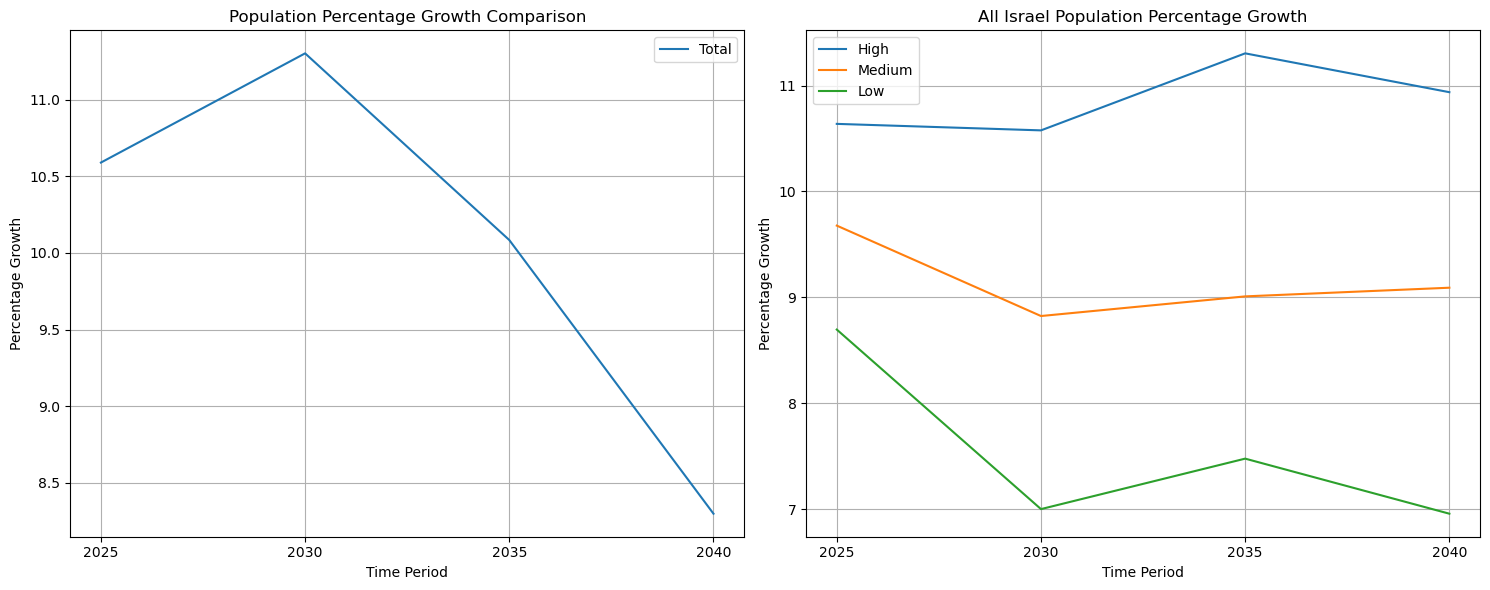

In [117]:
total = df_growth_percentage_with_total[df_growth_percentage_with_total['sector']=='Total']

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot the first plot on the left subplot
axs[0].plot(total[['2025','2030','2035','2040']].T)
axs[0].set_xlabel('Time Period')
axs[0].set_ylabel('Percentage Growth')
axs[0].set_title('Population Percentage Growth Comparison')
axs[0].legend(total['sector'])
axs[0].grid(True)

# Plot the second plot on the right subplot
axs[1].plot(df_growth_percentage_compare.T)
axs[1].set_xlabel('Time Period')
axs[1].set_ylabel('Percentage Growth')
axs[1].set_title('All Israel Population Percentage Growth')
axs[1].legend(df_growth_percentage_compare.index)
axs[1].grid(True)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure with both plots
plt.show()

the population growth rate in our data acts differently than the general population is forecasted to act, yet it does start similar with the high prediction and ends towards the lower prediction but nothing too crazy as we see that it is normal that the growth rate slows over time... 

## finding abnormal growth

In [34]:
all_rows_pop = df2[pop]

In [35]:
growth_percentage_abs = pd.DataFrame()

# Calculate percentage growth between first and last column
first_column = all_rows_pop.columns[0]
last_column = all_rows_pop.columns[-1]

growth_percentage_abs['GrowthRate'] = ((all_rows_pop[last_column] - all_rows_pop[first_column]) / all_rows_pop[first_column]) * 100

# Display the growth rate DataFrame

growth_percentage_abs.replace([np.inf, -np.inf], np.nan, inplace=True)
growth_percentage_abs.dropna(inplace=True)
growth_percentage_abs

,GrowthRate
0,-6.853122
1,34.155200
2,11.522845
3,-0.776893
4,15.275337
...,...
881,5.773039
883,22.019004
888,0.000000
895,65.925764


In [36]:
growth_percentage_abs[growth_percentage_abs['GrowthRate']>500]

,GrowthRate
30,700.000000
86,2994.637885
140,9999.999999
387,1393.286218
396,822.644426
464,547.408369
521,646.172447
523,1649.152035
741,1254.894180
785,1559.462482


In [37]:
abnormal = df2.loc[list(growth_percentage_abs[growth_percentage_abs['GrowthRate']>500].index)][['en_area name']+pop]

In [38]:
abnormal['GrowthRate'] = growth_percentage_abs[growth_percentage_abs['GrowthRate']>500]
abnormal

,en_area name,2020 population projections,Population projections 2025,Population projections 2030,2035 population projections,Population projections 2040,GrowthRate
30,Givat Ram campus,150.000000,150.000000,200.000000,600.000000,1200.000000,700.000000
86,Talfiot-Haumman St,42.350769,42.350769,42.350769,549.651641,1310.602949,2994.637885
140,Yaer Gila,18.078414,18.078414,18.078414,18.078414,1825.919824,9999.999999
387,Bh_s Boyer,17.683866,120.583866,175.183866,213.370733,264.070733,1393.286218
396,Ma_r intelligence,573.133407,1398.736965,2756.401045,4022.192238,5287.983432,822.644426
464,Mevasheret Zion Harel Mall,422.308252,422.308252,2734.058967,2734.058967,2734.058967,547.408369
521,Matityahu,898.000000,900.565714,3100.628571,6700.628571,6700.628571,646.172447
523,Modi'in Ilit Barchfeld Mizrah,464.800000,482.420000,1918.995732,7862.438661,8130.058661,1649.152035
741,Mantar,125.015523,129.645727,547.687052,965.728377,1693.828043,1254.894180
785,Beitar Ilit Giva C,523.673968,4243.641469,8690.173023,8690.173023,8690.173023,1559.462482


These places have an abnormal growth rate

## Comparing Actual 2020 population to 2020 forecast in data

### fixing and translating the data

In [39]:
url3 = 'https://raw.githubusercontent.com/gabirayman/Final-project-english/main/act_2020_translated.csv'
act_2020 = pd.read_csv(url3)
act_2020 = act_2020[['en_name','district','2020_population']]
act_2020

,en_name,district,2020_population
0,Abu Gosh,ירושלים,"7,769"
1,Abu Sanan,הצפון,"14,307"
2,Abu Qurinat (locality),הדרום,"1,994"
3,Abu Talul,הדרום,"2,139"
4,Abtin,חיפה,"2,887"
...,...,...,...
1279,rebirth,הדרום,741
1280,stuck,יהודה והשומרון,"4,168"
1281,Tarbin a-Tsana (locality)*,הדרום,"1,183"
1282,donate,ירושלים,962


In [40]:
url4 = 'https://raw.githubusercontent.com/gabirayman/Final-project-english/main/2020_real_pop.csv'
act_2020_heb = pd.read_csv(url4)
act_2020_heb.head(1)

,סמל היישוב,שם יישוב,מחוז,נפה,צורת יישוב,מעמד מוניציפלי,אזור טבעי,אוכלוסייה - סך הכל,מזה: יהודים ואחרים,מזה: יהודים,מזה: ערבים,אשכול רשויות מקומיות
0,472.0,אבו גוש,ירושלים,ירושלים,יישובים לא יהודיים 9999-5000 תושבים,מועצה מקומית,הרי יהודה,"7,769",86,68,"7,683",NaN


In [41]:
df2['Authority'].unique()

array(['Jerusalem', 'Headquarters Yehuda', 'Gush Etzion', 'Abu Gosh',
       'Kiryat Yaarim', "Ma'ale Adumim", 'Beit Shemesh', "Ze'ev hill",
       'Palestinian', 'Modiin', 'Gezer', 'Mata Binyamin', 'Hevel Modiin',
       'Mount Adar', 'Efrat', 'Mivaseret', 'Beitar Illit',
       "Modi'in Illit", 'Bethel', 'Kiryat Arba', 'Mount Hebron',
       'Megilot', 'Samaria area', 'Horns of Samaria', 'Alfie Menashe',
       'Emmanuel', 'Beit Arye', 'Bikah', 'Kedumim', 'Ariel', 'Ornit',
       'The Dead Sea Scrolls'], dtype=object)

In [42]:
d = {'Jerusalem': 'ירושלים',
 'Headquarters Yehuda': 'מטה יהודה',
 'Gush Etzion': 'גוש עציון',
 'Abu Gosh': 'אבו גוש',
 'Kiryat Yaarim': 'קריית יערים',
 "Ma'ale Adumim": 'מעלה אדומים',
 'Beit Shemesh': 'בית שמש',
 "Ze'ev hill": 'גבעת זאב',
 'Palestinian': 'פַּלֶשְׂתִינַאִי',
 'Modiin': 'מודיעין',
 'Gezer': 'גזר',
 'Mata Binyamin': "מטה בנימין",
 'Hevel Modiin': 'חבל מודיען',
 'Mount Adar': 'הר אדר',
 'Efrat': 'אפרת',
 'Mivaseret': 'מבשרת',
 'Beitar Illit': 'ביתר עילית',
 "Modi'in Illit": 'מודיעין עילית',
 'Bethel': 'בית אל',
 'Kiryat Arba': 'קריית ארבע',
 'Mount Hebron': 'הר חברון',
 'Megilot': 'מגילות',
 'Samaria area': 'אזור השומרון',
 'Horns of Samaria': 'קרני שומרון',
 'Alfie Menashe': 'אלפי מנשה',
 'Emmanuel': 'עמנואל',
 'Beit Arye': 'בית אריה',
 'Bikah': 'במיוחד',
 'Kedumim': 'קדומים',
 'Ariel': 'אריאל',
 'Ornit': 'אורנית',
 'The Dead Sea Scrolls': 'מגילות ים המלח'}

In [43]:
heb = list(d.values())

In [44]:
is_in = []
for word in heb:
    if word in list(act_2020_heb['שם יישוב']):
        is_in.append(word)
is_in

['ירושלים',
 'אבו גוש',
 'קריית יערים',
 'מעלה אדומים',
 'בית שמש',
 'גבעת זאב',
 'גזר',
 'הר אדר',
 'אפרת',
 'ביתר עילית',
 'מודיעין עילית',
 'בית אל',
 'קריית ארבע',
 'קרני שומרון',
 'אלפי מנשה',
 'עמנואל',
 'קדומים',
 'אריאל',
 'אורנית']

Translate Data

In [45]:
pip install googletrans==3.1.0a0

Note: you may need to restart the kernel to use updated packages.


In [46]:

from googletrans import Translator
translator = Translator()
is_in_new = []
for word in is_in:
    t = translator.translate(word).text
    is_in_new.append(t)

        
is_in_new

['Jerusalem',
 'Abu Gosh',
 'Kiryat Yearim',
 "Ma'ale Adumim",
 'Beit Shemesh',
 "Ze'ev hill",
 'Carrot',
 'Mount Adar',
 'Efrat',
 'Beitar Illit',
 "Modi'in Illit",
 'Bethel',
 'Kiryat Arba',
 'Horns of Samaria',
 'Alfie Menashe',
 'Emmanuel',
 'Ancients',
 'Ariel',
 'Ornit']

In [47]:
def switch(d):
    nd = {}
    dkey = list(d.keys())
    dval = list(d.values())
    for i in range(len(d)):
        nd[dval[i]] = dkey[i]
    return nd
switched = switch(d)
switched

{'ירושלים': 'Jerusalem',
 'מטה יהודה': 'Headquarters Yehuda',
 'גוש עציון': 'Gush Etzion',
 'אבו גוש': 'Abu Gosh',
 'קריית יערים': 'Kiryat Yaarim',
 'מעלה אדומים': "Ma'ale Adumim",
 'בית שמש': 'Beit Shemesh',
 'גבעת זאב': "Ze'ev hill",
 'פַּלֶשְׂתִינַאִי': 'Palestinian',
 'מודיעין': 'Modiin',
 'גזר': 'Gezer',
 'מטה בנימין': 'Mata Binyamin',
 'חבל מודיען': 'Hevel Modiin',
 'הר אדר': 'Mount Adar',
 'אפרת': 'Efrat',
 'מבשרת': 'Mivaseret',
 'ביתר עילית': 'Beitar Illit',
 'מודיעין עילית': "Modi'in Illit",
 'בית אל': 'Bethel',
 'קריית ארבע': 'Kiryat Arba',
 'הר חברון': 'Mount Hebron',
 'מגילות': 'Megilot',
 'אזור השומרון': 'Samaria area',
 'קרני שומרון': 'Horns of Samaria',
 'אלפי מנשה': 'Alfie Menashe',
 'עמנואל': 'Emmanuel',
 'בית אריה': 'Beit Arye',
 'במיוחד': 'Bikah',
 'קדומים': 'Kedumim',
 'אריאל': 'Ariel',
 'אורנית': 'Ornit',
 'מגילות ים המלח': 'The Dead Sea Scrolls'}

In [48]:
nd = {}
for i in range(len(is_in)):
    nd[is_in[i]] = switched[is_in[i]]
    
nd   

{'ירושלים': 'Jerusalem',
 'אבו גוש': 'Abu Gosh',
 'קריית יערים': 'Kiryat Yaarim',
 'מעלה אדומים': "Ma'ale Adumim",
 'בית שמש': 'Beit Shemesh',
 'גבעת זאב': "Ze'ev hill",
 'גזר': 'Gezer',
 'הר אדר': 'Mount Adar',
 'אפרת': 'Efrat',
 'ביתר עילית': 'Beitar Illit',
 'מודיעין עילית': "Modi'in Illit",
 'בית אל': 'Bethel',
 'קריית ארבע': 'Kiryat Arba',
 'קרני שומרון': 'Horns of Samaria',
 'אלפי מנשה': 'Alfie Menashe',
 'עמנואל': 'Emmanuel',
 'קדומים': 'Kedumim',
 'אריאל': 'Ariel',
 'אורנית': 'Ornit'}

In [49]:
en_is_in = list(nd.values())
en_is_in

['Jerusalem',
 'Abu Gosh',
 'Kiryat Yaarim',
 "Ma'ale Adumim",
 'Beit Shemesh',
 "Ze'ev hill",
 'Gezer',
 'Mount Adar',
 'Efrat',
 'Beitar Illit',
 "Modi'in Illit",
 'Bethel',
 'Kiryat Arba',
 'Horns of Samaria',
 'Alfie Menashe',
 'Emmanuel',
 'Kedumim',
 'Ariel',
 'Ornit']

In [50]:
for word in en_is_in:
    if word not in is_in_new:
        print(word)

Kiryat Yaarim
Gezer
Kedumim


In [51]:
act_comp = act_2020[act_2020['en_name'].isin(is_in_new)].copy()
act_comp.replace('Carrot','Gezer',inplace=True)
act_comp.replace('Kiryat Yarim','Kiryat Yaarim',inplace=True)
act_comp.replace('Ancients','Kedumim',inplace=True)
act_comp.columns = ['Authority','district','2020_population']
act_comp

,Authority,district,2020_population
0,Abu Gosh,ירושלים,"7,769"
44,Ornit,יהודה והשומרון,"8,966"
95,Alfie Menashe,יהודה והשומרון,"7,997"
108,Efrat,יהודה והשומרון,"11,405"
112,Ariel,יהודה והשומרון,"19,582"
148,Bethel,יהודה והשומרון,"5,684"
192,Beit Shemesh,ירושלים,"132,543"
196,Beitar Illit,יהודה והשומרון,"61,125"
256,Ze'ev hill,יהודה והשומרון,"19,225"
284,Gezer,המרכז,292


In [52]:
df_comp = df2[df2['Authority'].isin(en_is_in)]
df_comp = df_comp.groupby('Authority').sum()
df_comp = df_comp.reset_index()
df_comp = df_comp[['Authority','2020 population projections']]
df_comp

,Authority,2020 population projections
0,Abu Gosh,8.524002e+03
1,Alfie Menashe,8.015296e+03
2,Ariel,2.183000e+04
3,Beit Shemesh,1.250729e+05
4,Beitar Illit,5.927000e+04
5,Bethel,5.973000e+03
6,Efrat,1.185473e+04
7,Emmanuel,4.841800e+03
8,Gezer,5.361000e+03
9,Horns of Samaria,1.038450e+04


### Finding difference between actual population and forecast in our data, we will merge the dataframes and compare

In [53]:
merged_df = pd.merge(df_comp, act_comp, on='Authority')
merged_df['2020_population'] = merged_df['2020_population'].str.replace(',', '').astype(int)
merged_df['over'] = merged_df['2020 population projections']-merged_df['2020_population']
merged_df['under'] = merged_df['2020_population']-merged_df['2020 population projections']
merged_df['over'] = merged_df['over'].apply(lambda x: 0 if x < 0 else x)
merged_df['under'] = merged_df['under'].apply(lambda x: 0 if x < 0 else x)
merged_df

,Authority,2020 population projections,district,2020_population,over,under
0,Abu Gosh,8.524002e+03,ירושלים,7769,755.001924,0.000000
1,Alfie Menashe,8.015296e+03,יהודה והשומרון,7997,18.296125,0.000000
2,Ariel,2.183000e+04,יהודה והשומרון,19582,2248.000000,0.000000
3,Beit Shemesh,1.250729e+05,ירושלים,132543,0.000000,7470.100000
4,Beitar Illit,5.927000e+04,יהודה והשומרון,61125,0.000000,1855.000001
5,Bethel,5.973000e+03,יהודה והשומרון,5684,289.000000,0.000000
6,Efrat,1.185473e+04,יהודה והשומרון,11405,449.732502,0.000000
7,Emmanuel,4.841800e+03,יהודה והשומרון,4128,713.800000,0.000000
8,Gezer,5.361000e+03,המרכז,292,5069.000000,0.000000
9,Horns of Samaria,1.038450e+04,יהודה והשומרון,9417,967.500000,0.000000


In [54]:
# Gezer in our data is the area council of gezer, and in the actual population data it is the settlement of gezer, so we will remove gezer
merged_df_clean = merged_df[merged_df['Authority']!='Gezer'].copy()
merged_df_clean['difference'] = merged_df_clean['2020 population projections']-merged_df_clean['2020_population']
merged_df_clean['percent_dif'] = merged_df_clean['difference']/merged_df_clean['2020_population']

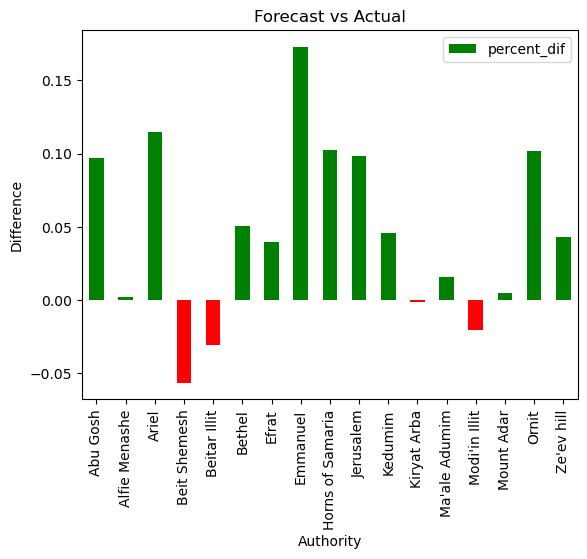

In [55]:
merged_df_clean['negative'] = merged_df_clean['percent_dif'] < 0

# Set the color map to red for negative values, and blue for positive values
colors = np.where(merged_df_clean['negative'], 'red', 'green')

# Plot the bar chart with different colors for negative and positive values
ax = merged_df_clean.plot(x='Authority', y='percent_dif', kind='bar', stacked=False,
                        color=colors, title='Forecast vs Actual')

# Set the x-axis label
ax.set_xlabel('Authority')


ax.set_ylabel('Difference')


plt.show();

## Testing Population accuracy by comparing to living units forecast

In [56]:
df2.columns

Index(['OBJECTID', 'Traffic area', 'TAZ_Number', 'en_area name', 'Authority',
       'Inside the city of Jerusalem?', 'Inside the Jerusalem metropolis?',
       'sector', 'A total of one until 2020', 'Additional unit 2020_ 2025',
       'Additional unit 2025_ 2030', 'Additional unit 2030_ 2035',
       'Addendum y_d 2035_ 2040', 'Total addition between 2020_2040',
       'A total of one until 2040', 'Gm_b average 2020', 'Gm_b average 2025',
       'Gm_b average 2030', 'Gm_b average 2035', 'Gm_b average 2040',
       '2020 population projections', 'Population projections 2025',
       'Population projections 2030', '2035 population projections',
       'Population projections 2040', 'Total students 2020',
       'Total students 2025', 'Total students 2030', 'Total students 2035',
       'Total students 2040', 'Total employed 2020', 'Total employed 2025',
       'Total employed 2030', 'Total employed 2035', 'Total employed 2040',
       'Total Yeshiva students and include 2020',
       '

In [57]:
df_unit_test = df2[['en_area name','2020 population projections', 'Population projections 2025',
       'Population projections 2030', '2035 population projections',
       'Population projections 2040','A total of one until 2020', 'Additional unit 2020_ 2025',
       'Additional unit 2025_ 2030', 'Additional unit 2030_ 2035',
       'Addendum y_d 2035_ 2040', 'Total addition between 2020_2040','Gm_b average 2020', 'Gm_b average 2025',
       'Gm_b average 2030', 'Gm_b average 2035', 'Gm_b average 2040']].copy()

In [58]:
df_unit_test.columns = ['name','2020_pop', '2025_pop',
       '2030_pop','2035_pop',
       '2040_pop','2020_units', '2020_2025_add_unit',
       '2025_2030_add_unit', '2030_2035_add_unit',
       '2035_2040_add_unit', '2020_2040_Tot_add_unit','2020_pph', '2025_pph',
       '2030_pph', '2035_pph', '2040_pph']

In [59]:
df_unit_test['2025_tot_units'] = df_unit_test['2020_units'] + df_unit_test['2020_2025_add_unit']
df_unit_test['2030_tot_units'] = df_unit_test['2025_tot_units'] + df_unit_test['2025_2030_add_unit']
df_unit_test['2035_tot_units'] = df_unit_test['2030_tot_units'] + df_unit_test['2030_2035_add_unit']
df_unit_test['2040_tot_units'] = df_unit_test['2035_tot_units'] + df_unit_test['2035_2040_add_unit']

In [60]:
columns_to_calc = ['2020_pop', '2025_pop', '2030_pop', '2035_pop', '2040_pop']
columns_to_devide = ['2020_pph', '2025_pph', '2030_pph', '2035_pph', '2040_pph']

for i in range(len(columns_to_calc)):
    pop = columns_to_calc[i]
    pph = columns_to_devide[i]
    new_column_name = f"{pop[:4]}_needed"
    df_unit_test[new_column_name] = df_unit_test[pop] / df_unit_test[pph]
df_unit_test.columns

Index(['name', '2020_pop', '2025_pop', '2030_pop', '2035_pop', '2040_pop',
       '2020_units', '2020_2025_add_unit', '2025_2030_add_unit',
       '2030_2035_add_unit', '2035_2040_add_unit', '2020_2040_Tot_add_unit',
       '2020_pph', '2025_pph', '2030_pph', '2035_pph', '2040_pph',
       '2025_tot_units', '2030_tot_units', '2035_tot_units', '2040_tot_units',
       '2020_needed', '2025_needed', '2030_needed', '2035_needed',
       '2040_needed'],
      dtype='object')

In [61]:
df_needed_vs_forecast = df_unit_test[['2020_units','2025_tot_units', '2030_tot_units', '2035_tot_units', '2040_tot_units', '2020_needed',
       '2025_needed', '2030_needed', '2035_needed', '2040_needed']]
df_needed_vs_forecast

,2020_units,2025_tot_units,2030_tot_units,2035_tot_units,2040_tot_units,2020_needed,2025_needed,2030_needed,2035_needed,2040_needed
0,843.636364,848.828030,854.019697,859.211364,864.403030,843.636364,848.828030,854.019697,859.211364,864.403030
1,932.232276,941.132276,950.032276,958.932276,967.832276,932.232276,941.132276,950.032276,958.932276,967.832276
2,1048.275000,1048.275000,1118.275000,1148.075000,1178.075000,1048.275000,1048.275000,1118.275000,1148.075000,1178.075000
3,973.076923,1045.976923,1045.976923,1045.976923,1045.976923,973.076923,1045.976923,1045.976923,1045.976923,1045.976923
4,604.500000,680.100000,680.100000,686.100000,700.100000,604.500000,680.100000,680.100000,686.100000,700.100000
...,...,...,...,...,...,...,...,...,...,...
892,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
893,0.000000,0.000000,0.000000,480.000000,960.000000,NaN,NaN,NaN,480.000000,960.000000
894,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
895,1717.061843,2000.058377,2283.054912,2566.051446,2849.047981,1717.061843,2000.058377,2283.054911,2566.051446,2849.047980


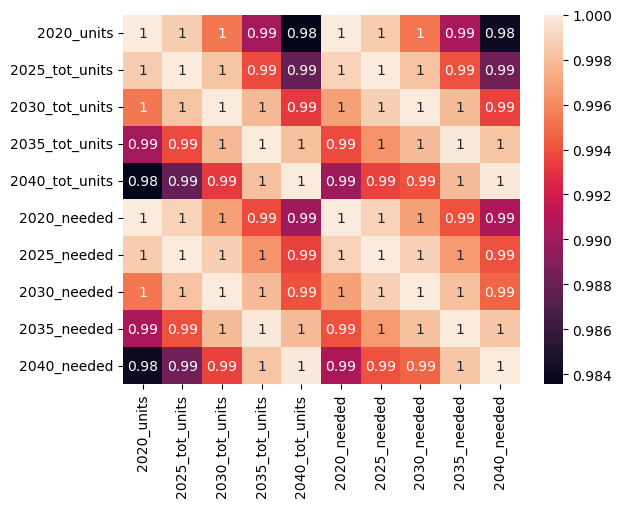

In [62]:
heat = df_needed_vs_forecast.corr()
sns.heatmap(heat,annot=True);

In [63]:
df_needed_vs_forecast[['2030_tot_units','2030_needed']]

,2030_tot_units,2030_needed
0,854.019697,854.019697
1,950.032276,950.032276
2,1118.275000,1118.275000
3,1045.976923,1045.976923
4,680.100000,680.100000
...,...,...
892,0.000000,NaN
893,0.000000,NaN
894,0.000000,NaN
895,2283.054912,2283.054911


We see that if you devide the population by the avg. people per house, we get the total units in our original data.
we understand from this that the units data was not forecasted by the amount of buildings
that will be built rather it leans on the population forecast. 
which can be problematic if the population forecast data did not take into account the units and only looked at past population and forecasted the future. 

# population suspicious jumps

There are 11 rows that jump with consistant numbers

there are 13 rows that the population does not change

In [89]:
reliable_data['population'].value_counts()

0    750
1    136
2     11
Name: population, dtype: int64

In [90]:
suspect_population1 = reliable_data[reliable_data['population']==1]
suspect_population1['area name'].unique()

array(['הר הרצל', 'ממילא', 'פיקוד מרכז', 'מלון המלך דוד', 'גן הורדים',
       'מוזיאון ישראל', 'מוזיאון המדע', 'מצפה נפתוח', 'עמק הארזים',
       'הר המנוחות', 'חניון תפעולי - עיריית ירושלים',
       'עין כרם - בהס חקלאי', 'סטף', 'הר שלמון מערב', 'הר שלמון מזרח',
       'רכס לבן מערב', 'בה_ח שערי צדק', 'גן החיות התנכי', 'עמק הצבאים',
       'עמק ליפתא', 'הכפר השוודי', 'מחסום חיזמא', 'סיבוב מוצא',
       'הר חרת מערב', 'גבעת רם - מעונות', 'מכללות - מורדות בית וגן',
       'עטרות מזרח', 'א_ת עטרות', 'עטרות דרום', 'נוה יעקב - מוסדות חינוך',
       'חנה וסע נחל צופים', 'אוגוסטה ויקטוריה', 'קמפוס הר הצופים',
       'חנה וסע גבעת התחמושת', 'גבעת התחמושת', "שיח ג'ראח - מרכזי בריאות",
       'משרד ראש הממשלה החדש', 'קרית בן גוריון', 'קרית הממשלה משרד החוץ',
       'כפר שאול', 'גבעת שאול - למס_', 'גבעת שאול - בית המשפט',
       'נוף ציון', 'יער רמות - דרום', 'מחלף 4/9', 'הר חוצבים א',
       'הר חוצבים ד', 'הר חוצבים', 'הר רפאים', 'כביש מעלה אדומים דרום',
       'אזור תעשיה מערבי (ברוש)', nan, 

a row that has all of its values 0 is a location not populated. we will show type 1 exceptions for places that are populated

In [91]:
suspect_population1_0 = suspect_population1[suspect_population1['2020 population projections']!=0.0][parameters+['2020 population projections',
       'Population projections 2025', 'Population projections 2030',
       '2035 population projections', 'Population projections 2040']]
suspect_population1_0

,en_area name,area name,Authority,sector,2020 population projections,Population projections 2025,Population projections 2030,2035 population projections,Population projections 2040
41,in any case,ממילא,Jerusalem,Jewish,878.400000,878.400000,878.400000,878.400000,878.400000
108,King David Hotel,מלון המלך דוד,Jerusalem,Jewish,87.059552,87.059552,87.059552,87.059552,87.059552
196,Givat Ram - dormitory,גבעת רם - מעונות,Jerusalem,Jewish,600.000000,600.000000,600.000000,600.000000,600.000000
197,Colleges - home and garden slopes,מכללות - מורדות בית וגן,Jerusalem,Jewish,229.500000,229.500000,229.500000,229.500000,229.500000
355,Pisgat Ze'ev East - North,פסגת זאב מזרח - צפון,Jerusalem,Jewish,1872.500000,1872.500000,1872.500000,1872.500000,1872.500000
357,Pisgat Ze'ev Mizrah - Mizrah,פסגת זאב מזרח - מזרח,Jerusalem,Jewish,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000
404,Maccabi,מכבים,Modiin,Jewish,2980.000000,2980.000000,2980.000000,2980.000000,2980.000000
468,"Mevasheret Zion, neighborhood 11",מבשרת ציון שכונה יא',Mivaseret,Jewish,1903.720000,1903.720000,1903.720000,1903.720000,1903.720000
842,Givat Mashua Mizrah,גבעת משואה מזרח,Jerusalem,Jewish,2376.000000,2376.000000,2376.000000,2376.000000,2376.000000
843,West Beacon Hill,גבעת משואה מערב,Jerusalem,Jewish,2001.600000,2001.600000,2001.600000,2001.600000,2001.600000


In [92]:
len(suspect_population1_0)

13

there are 13 rows that the population does not change

In [93]:
suspect_population2 = reliable_data[reliable_data['population']==2]
suspect_population2['area name'].unique()

array(['הרובע הנוצרי', 'הרובע הארמני', 'הרובע המוסלמי', 'אוהל משה', 'מטע',
       'מבשרת הישנה מזרח', "מעוז ציון ב'", 'שז_ר', 'פסגות / כוכב יעקב',
       "רובע ב' מזרח/מוריה", 'אריאל רובע א-ב'], dtype=object)

In [94]:
suspect_population2[parameters+['2020 population projections',
       'Population projections 2025', 'Population projections 2030',
       '2035 population projections', 'Population projections 2040']]

,en_area name,area name,Authority,sector,2020 population projections,Population projections 2025,Population projections 2030,2035 population projections,Population projections 2040
36,The Christian quarter,הרובע הנוצרי,Jerusalem,Arab,3971.100000,4002.100000,4033.100000,4064.100000,4095.100000
44,The Armenian quarter,הרובע הארמני,Jerusalem,Arab,2327.500000,2362.500000,2397.500000,2432.500000,2467.500000
155,Muslim Quarter,הרובע המוסלמי,Jerusalem,Arab,26045.640000,26183.140000,26320.640000,26458.140000,26595.640000
319,Moses' tent,אוהל משה,Jerusalem,Jewish,814.500000,829.500000,844.500000,859.500000,874.500000
340,plantation,מטע,Headquarters Yehuda,Jewish,962.500000,1015.000000,1067.500000,1120.000000,1172.500000
461,The old harbinger of Mizrah,מבשרת הישנה מזרח,Mivaseret,Jewish,3103.233629,3208.233629,3313.233629,3418.233629,3523.233629
471,Mauz Zion B,מעוז ציון ב',Mivaseret,Jewish,4986.800000,5126.800000,5266.800000,5406.800000,5546.800000
517,Shaz_r,שז_ר,Beit Shemesh,Ultra Orthodox,5128.200000,5191.200000,5254.200000,5317.200000,5380.200000
739,Psagot / Kochav Yaakov,פסגות / כוכב יעקב,Mata Binyamin,Jewish,3465.000000,3740.000000,4015.000000,4290.000000,4565.000000
771,District B Mizrah/Muria,רובע ב' מזרח/מוריה,Ariel,Jewish,9435.000000,9805.000000,10175.000000,10545.000000,10915.000000


There are 11 rows that jump with consistant numbers

# Higher education

without special findings.  
&nbsp;&nbsp;&nbsp;&nbsp;Any row with values other than 0 is actually an institution of higher education

In [64]:
reliable_data['Higher education students'].value_counts()

1    880
0     17
Name: Higher education students, dtype: int64

In [65]:
reliable_data[reliable_data['Higher education students']==0][parameters+['Higher education students 2020', 'Higher education students 2025',
       'Higher education students 2030', 'Higher education students 2035','Higher education students 2040']]

,en_area name,area name,Authority,sector,Higher education students 2020,Higher education students 2025,Higher education students 2030,Higher education students 2035,Higher education students 2040
30,Givat Ram campus,קמפוס גבעת רם,Jerusalem,Jewish,5846.700,6263.520000,6710.517375,7189.901222,7704.043609
34,Beit Kerem Center,בית הכרם מרכז,Jerusalem,Jewish,1674.750,1758.487500,1846.411875,1938.732469,2035.669092
45,Niyot,ניות,Jerusalem,Jewish,408.500,439.137500,472.072812,507.478273,545.539144
92,Kiryat Moriah,קרית מוריה,Jerusalem,Jewish,148.350,170.602500,196.192875,225.621806,259.465077
110,Russian court,מגרש הרוסים,Jerusalem,Jewish,0.000,0.000000,2500.000000,2500.000000,2500.000000
113,The national institutions,המוסדות הלאומיים,Jerusalem,Jewish,135.200,175.760000,228.488000,297.034400,386.144720
171,Bezalel - Architecture,בצלאל - ארכיטקטורה,Jerusalem,Jewish,387.000,416.025000,447.226875,480.768891,516.826557
197,Colleges - home and garden slopes,מכללות - מורדות בית וגן,Jerusalem,Jewish,5592.260,6031.535300,6505.344712,7016.405370,7567.648362
213,Beit Hanina South,בית חנינא דרום,Jerusalem,Arab,3150.000,3307.500000,3472.875000,3646.518750,3828.844688
232,Mount Scopus campus,קמפוס הר הצופים,Jerusalem,Jewish,11625.000,11857.500000,12094.650000,12336.543000,12583.273860


The suspicious rows (which received a score of 1) are simply rows that do not have universities

In [66]:
suspect_Higher_education = reliable_data[reliable_data['Higher education students']==1]
suspect_Higher_education[parameters+['Higher education students 2020', 'Higher education students 2025',
       'Higher education students 2030', 'Higher education students 2035','Higher education students 2040']].describe()

,Higher education students 2020,Higher education students 2025,Higher education students 2030,Higher education students 2035,Higher education students 2040
count,880.0,880.0,880.0,880.0,880.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


# yeshiva students and kollel

In [67]:
reliable_data['Yeshiva students'].value_counts()

1    765
0    132
Name: Yeshiva students, dtype: int64

In [68]:
reg_Yeshiva_students = reliable_data[reliable_data['Yeshiva students']==0]
suspect_Yeshiva_students = reliable_data_true_rows_full[reliable_data_true_rows_full['Yeshiva students']==1]

In [69]:
print (len(suspect_Yeshiva_students))
print (len(reg_Yeshiva_students))

69
132


There are a total of 201 yeshivas, 69 of which have suspicious data

The yeshivas with the "suspicious" data

In [70]:
suspect_Yeshiva_students['sector'].value_counts()

Jewish            60
Ultra Orthodox     5
Arab               4
Name: sector, dtype: int64

The yeshiva in the Arab regions are actually Jewish yeshiva and this is not unusual.

In [71]:
real_yeshiva = pd.concat([suspect_Yeshiva_students, reg_Yeshiva_students])
real_yeshiva['sector'].replace(['Arab','Jewish'],'non Ultra Orthodox',inplace=True) 
real_yeshiva.drop(real_yeshiva[real_yeshiva['sector'].isin(['Arabs beyond the separation fence','Palestinian'])].index,inplace=True)


In [72]:
grouped_data = real_yeshiva.groupby('sector').agg({'Total Yeshiva students and include 2025': 'count', 'Yeshiva students': 'sum', 'Total Yeshiva students and include 2020': 'sum'})
grouped_data.columns = ['number_of_yeshivot','abnormal_yeshivot','number_of_students_2020']
grouped_data['abnormal_yeshivot_students_2020']= real_yeshiva[real_yeshiva['Yeshiva students']==1].groupby('sector')[['Total Yeshiva students and include 2025']].sum()['Total Yeshiva students and include 2025']
grouped_data

,number_of_yeshivot,abnormal_yeshivot,number_of_students_2020,abnormal_yeshivot_students_2020
sector,,,,
Ultra Orthodox,133,5,82092.650394,1720.296148
non Ultra Orthodox,68,64,10253.800895,9293.000000


It is important to say that the division into ultra-orthodox/non-orthodox yeshiva is based on neighborhoods, so there is a caveat that it is possible that non-orthodox yeshiva are actually ultra-orthed yeshiva, but on the other hand yeshiva in ultra-orthed areas are very likely ultra-orthed.

In the non-Orthodox sector there are 68 yeshivas, of which 64 yeshivas have abnormal data

In the ultra-orthodox sector there are 133 yeshiva, including 5 yeshiva with abnormal data

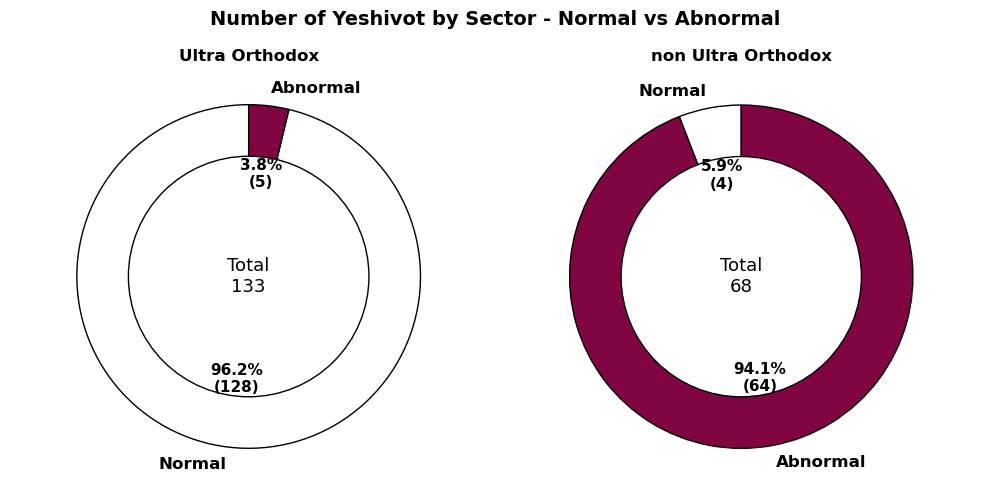

In [73]:
sectors = grouped_data.index
yeshivot = grouped_data['number_of_yeshivot']
abnormal_yeshivot = grouped_data['abnormal_yeshivot']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

colors = ['white','#810541']

for i, ax in enumerate(axs):    
    data1 = [yeshivot[i] - abnormal_yeshivot[i], abnormal_yeshivot[i]]    
    wedges, texts, autotexts = ax.pie(data1, labels=['Normal', 'Abnormal'],colors=colors, autopct='%1.1f%%', startangle=90, 
                                      textprops={'fontsize': 12, 'fontweight': 'bold'},
                                     wedgeprops={'linewidth': 1, 'edgecolor': 'black'})
  
    center_circle = plt.Circle((0, 0), 0.70, fc='white',ec ='black' )
    ax.add_artist(center_circle)    
    ax.set_title(sectors[i], fontweight='bold')    
    ax.axis('equal')    
    for autotext in autotexts:        
        autotext.set_fontsize(11)            
        index = autotexts.index(autotext)
        text = texts[index].get_text()
        percentage = autotext.get_text()
        value = data1[index]
        autotext.set_text(f'{percentage}\n({value})')
    total = sum(data1)
    ax.text(0, 0, f'Total\n{total}', ha='center', va='center', fontsize=13)
fig.suptitle('Number of Yeshivot by Sector - Normal vs Abnormal', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [74]:
Yeshiva = data[['sector','en_area name', 'area name','Total Yeshiva students and include 2020',
       'Total Yeshiva students and include 2025',
       'Total Yeshiva students and include 2030',
       'Total yeshiva students and include 2035',
       'Total Yeshiva students including 2040']]

In [75]:
Yeshiva_in_haredim_area = Yeshiva.query('sector == "Ultra Orthodox"')
Yeshiva_pop_in_haredim_area = data[['sector','en_area name', 'area name',
       'Total Yeshiva students and include 2020',
       'Total Yeshiva students and include 2025',
       'Total Yeshiva students and include 2030',
       'Total yeshiva students and include 2035',
       'Total Yeshiva students including 2040','2020 population projections', 'Population projections 2025',
       'Population projections 2030', '2035 population projections',
       'Population projections 2040']].query('sector == "Ultra Orthodox"')

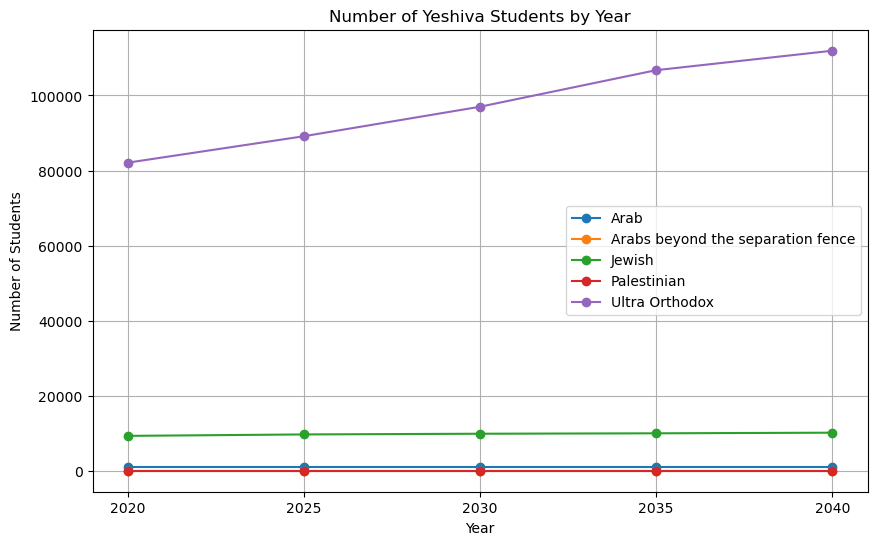

In [76]:
faetures_yeshiva = ['Total Yeshiva students and include 2020',
       'Total Yeshiva students and include 2025',
       'Total Yeshiva students and include 2030',
       'Total yeshiva students and include 2035',
       'Total Yeshiva students including 2040']
grouped_df = Yeshiva.groupby('sector')[faetures_yeshiva].sum()

plt.figure(figsize=(10, 6)) 
x = ['2020','2025','2030','2035','2040']
for sector in grouped_df.index:
    plt.plot(grouped_df.columns, grouped_df.loc[sector], marker='o', label=sector)

plt.xticks(range(len(grouped_df.columns)),x)
plt.xlabel('Year')
plt.ylabel('Number of Students')
plt.title('Number of Yeshiva Students by Year')
plt.legend()
plt.grid(True)
plt.show()

We will try to show the ratio of Yeshiva students in relation to the population

In [77]:
faetures_yeshiva_pop = ['2020 population projections', 'Population projections 2025',
       'Population projections 2030', '2035 population projections',
       'Population projections 2040']
grouped_pop_df = data.groupby('sector')[faetures_yeshiva_pop].sum()

In [78]:
ratio_haredim_pop_yeshiva = []
for i in range(5):
    ratio = ((grouped_df.iloc[-1, i]/grouped_pop_df.iloc[-1, i])*100).round(2)
    ratio_haredim_pop_yeshiva.append(ratio)
ratio_df = pd.DataFrame(ratio_haredim_pop_yeshiva,columns=['ratio'])
ratio_df.index = x

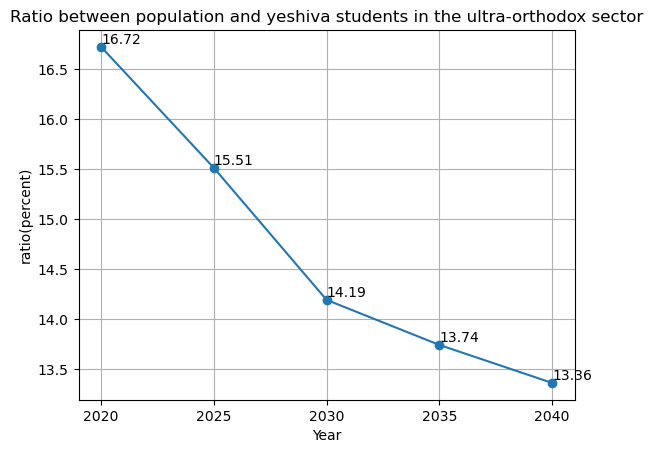

In [79]:
plt.plot(ratio_df, marker='o')
for i, value in enumerate(ratio_df['ratio']):
    plt.text(ratio_df.index[i], value, str(value), ha='left', va='bottom')
plt.xlabel('Year')
plt.ylabel('ratio(percent)')
plt.title('Ratio between population and yeshiva students in the ultra-orthodox sector')
plt.grid(True)
plt.show()

In [80]:
ratio_Jewish_pop_yeshiva = []
for i in range(5):
    ratio2 = (((grouped_df.iloc[0, i]+grouped_df.iloc[3, i])/grouped_pop_df.iloc[3, i])*100).round(4)
    ratio_Jewish_pop_yeshiva.append(ratio2)
ratio_Jewish_df = pd.DataFrame(ratio_Jewish_pop_yeshiva,columns=['ratio'])
ratio_Jewish_df.index = x
ratio_Jewish_df

,ratio
2020,0.0352
2025,0.0322
2030,0.0297
2035,0.0277
2040,0.0261


In the non-Orthodox sector, the ratio does not decrease at the same rate

# employed

Each row represents an employment area

In [81]:
reliable_data['Total employed'].value_counts()

0    834
1     63
Name: Total employed, dtype: int64

In [82]:
suspect_Total_employed = reliable_data[reliable_data['Total employed']==1]
suspect_Total_employed[parameters+['Total employed 2020','Total employed 2025', 'Total employed 2030', 'Total employed 2035',
       'Total employed 2040']].head(3)

,en_area name,area name,Authority,sector,Total employed 2020,Total employed 2025,Total employed 2030,Total employed 2035,Total employed 2040
113,The national institutions,המוסדות הלאומיים,Jerusalem,Jewish,1091.063164,1091.063164,1091.063164,1091.063164,1091.063164
123,Emek Arazim,עמק הארזים,Jerusalem,Jewish,0.000000,0.000000,0.000000,0.000000,0.000000
131,Steph,סטף,Jerusalem,Jewish,0.000000,0.000000,0.000000,0.000000,0.000000


We will only represent suspicious lines as lines where there are employees in 2020

In [83]:
suspect_Total_employed0 = suspect_Total_employed[suspect_Total_employed['Total employed 2020']!=0.0]
suspect_Total_employed0[parameters+['Total employed 2020','Total employed 2025', 'Total employed 2030', 'Total employed 2035',
       'Total employed 2040']]

,en_area name,area name,Authority,sector,Total employed 2020,Total employed 2025,Total employed 2030,Total employed 2035,Total employed 2040
113,The national institutions,המוסדות הלאומיים,Jerusalem,Jewish,1091.063164,1091.063164,1091.063164,1091.063164,1091.063164
360,Ramat Shlomo - Southwest,רמת שלמה - דרום מערב,Jerusalem,Ultra Orthodox,394.120833,394.120833,394.120833,394.120833,394.120833
445,the good samaritan,השומרוני הטוב,Mata Binyamin,Jewish,50.000000,50.000000,50.000000,50.000000,50.000000
468,"Mevasheret Zion, neighborhood 11",מבשרת ציון שכונה יא',Mivaseret,Jewish,47.488063,47.488063,47.488063,47.488063,47.488063
520,Matthiyahu industrial zone,מתתיהו אזור תעשייה,Mata Binyamin,Ultra Orthodox,250.000000,250.000000,250.000000,250.000000,250.000000
654,Anat camp,מחנה ענתות,Ma'ale Adumim,Jewish,250.000000,250.000000,250.000000,250.000000,250.000000
842,Givat Mashua Mizrah,גבעת משואה מזרח,Jerusalem,Jewish,103.187333,103.187333,103.187333,103.187333,103.187333
843,West Beacon Hill,גבעת משואה מערב,Jerusalem,Jewish,51.524733,51.524733,51.524733,51.524733,51.524733
845,Pisgat Ze'ev Center - East,פסגת זאב מרכז - מזרח,Jerusalem,Jewish,121.291500,121.291500,121.291500,121.291500,121.291500


יש 9 מקומות תעסוקה חריגים

לא משהו מעניין במיוחד

נבדוק מה קורה בשורות הלא חריגות

In [84]:
real_Total_employed = reliable_data[reliable_data['Total employed']==0][parameters+['Total employed 2020','Total employed 2025', 'Total employed 2030', 'Total employed 2035',
       'Total employed 2040']]

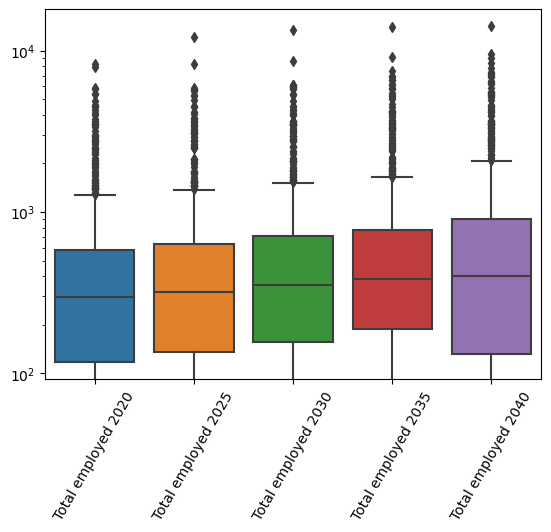

In [85]:
ax = sns.boxplot(data=real_Total_employed)
ax.set_yscale("log")
ax.tick_params(axis = 'x', rotation = 60)
plt.show()

In [86]:
max_ = real_Total_employed['Total employed 2025'].idxmax()
real_Total_employed.loc[[max_]]

,en_area name,area name,Authority,sector,Total employed 2020,Total employed 2025,Total employed 2030,Total employed 2035,Total employed 2040
329,Mount Hozvim,הר חוצבים,Jerusalem,Jewish,8302.773769,12131.2652,13412.60078,14102.89796,14188.64408


הנתון החריג הוא הר החוצבים שזה אזור תעסוקה הכי גדול בירושלים

סה"כ נראה שהנתונים מתנהגים בצורה נורמלית.. אולי הקופסא של 2040 קצת משונה

In [87]:
real_Total_employed.describe()

,Total employed 2020,Total employed 2025,Total employed 2030,Total employed 2035,Total employed 2040
count,834.000000,834.000000,834.000000,834.000000,834.000000
mean,550.510313,606.243616,671.819637,745.672214,836.640999
std,862.979264,963.246034,1055.044241,1163.750954,1366.660380
min,-95.000000,-95.000000,-50.385489,0.000000,0.000000
25%,117.366327,135.876646,157.279352,187.579525,132.652647
50%,296.215161,320.573109,350.527170,383.436125,400.068522
75%,581.826467,637.541379,707.419290,771.995557,909.462429
max,8302.773769,12131.265200,13412.600780,14102.897960,14188.644080


In [88]:
min_ = real_Total_employed['Total employed 2025'].idxmin()
real_Total_employed.loc[[min_]]

,en_area name,area name,Authority,sector,Total employed 2020,Total employed 2025,Total employed 2030,Total employed 2035,Total employed 2040
661,T. South,ט' דרום,Beit Shemesh,Jewish,-95.0,-95.0,-50.385489,0.0,121.3674
